<div style="background-color:#ecf0f1; color:#2c3e50; padding:15px; border-radius:10px; text-align:center; font-size:24px;">
    📦 Import Libraries
</div>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: /Users/rohitgupta/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [3]:
import os

# List the files in the dataset directory
dataset_path = "/Users/rohitgupta/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1"
files = os.listdir(dataset_path)
print(files)


['images', 'annotations']


In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
from tensorflow.keras.optimizers import Adam
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
import os


<div style="background-color:#ecf0f1; color:#16a085; padding:15px; border-radius:10px; text-align:center; font-size:24px;">
    📊 Import Data
</div>

In [5]:
# Function to parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize variables for the image details
    label = None

    # Parse XML to get the label
    for member in root.findall('object'):
        label = member.find('name').text
        # Assuming we only need the label, not bounding box coordinates

    return label

In [6]:
# Paths
annotations_dir = '/Users/rohitgupta/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/annotations'
images_dir = '/Users/rohitgupta/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1/images'

# Initialize lists to hold data
image_data = []
labels = []

# Loop over each XML file in the annotations folder
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        # Parse the XML to get the label
        xml_path = os.path.join(annotations_dir, xml_file)
        label = parse_xml(xml_path)

        # Corresponding image file
        image_file = xml_file.replace('.xml', '.png')
        image_path = os.path.join(images_dir, image_file)
        
        # Check if the image file exists
        if os.path.exists(image_path):
            # Read and resize image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Resize to 128x128

            # Flatten the image for ANN
            image_flat = image.flatten()

            # Append data to lists
            image_data.append(image_flat)
            labels.append(label)

# Convert to numpy arrays
X = np.array(image_data)
y = np.array(labels)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [7]:
from sklearn.preprocessing import LabelBinarizer

# Encode labels (e.g., 'with_mask' -> 0, 'without_mask' -> 1)
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [8]:
# Convert y_encoded to a Numpy array 
y_encoded = np.array(y_encoded)

In [9]:
# Convert y_encoded to categorical if it's binary and single-label
if len(y_encoded.shape) == 1:
    print("true")
    y_encoded = to_categorical(y_encoded)

<div style="background-color:#8e44ad; color:white; padding:15px; border-radius:10px; text-align:center; font-size:24px;">
    🖼️ Visualization
</div>

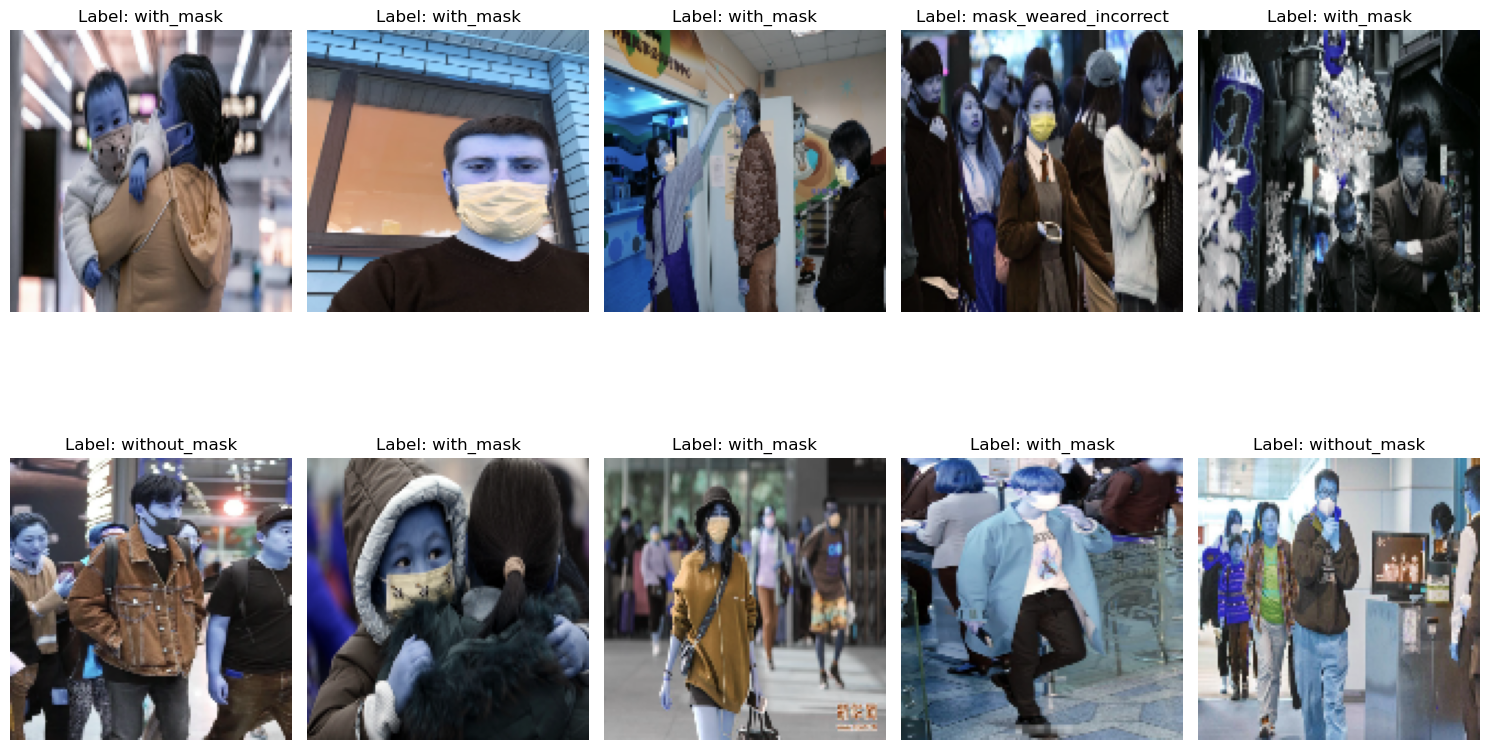

In [10]:
# Function to visualize images with their labels
def visualize_images(X, y_encoded, label_encoder, num_images=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X)), num_images)
    
    for i, idx in enumerate(indices):
        # Reshape the flattened image back to original dimensions
        image = X[idx].reshape(128, 128, 3)
        
        # Get the label index
        label_index = y_encoded[idx]
        
        # Decode the label
        label = label_encoder.inverse_transform([label_index])[0]
        
        # Plot each image in a grid
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.astype('uint8'))
        plt.title(f'Label: {label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Fit the label encoder and transform labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Call the visualization function
visualize_images(X, y_encoded, label_encoder, num_images=10)

<div style="background-color:#2980b9; color:#ffffff; padding:15px; border-radius:10px; text-align:center; font-size:24px;">
    🏗️ Model Building
</div>

In [11]:
# Normalize pixel values to the range [0, 1]
X_normalized = X / 255.0

# One-hot encode labels for ANN 
y_encoded_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded_one_hot, test_size=0.2, random_state=42)

# Check the shape of the training and testing data
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (682, 49152), Training labels shape: (682, 3)
Testing data shape: (171, 49152), Testing labels shape: (171, 3)


**Building the Artificial Neural Network (ANN)**

In [12]:
# Build the ANN model
model = Sequential([
    Flatten(input_shape=(49152,)),  # Flatten the 128x128x3 image to a 1D vector
    Dense(256, activation='relu'),  # Hidden layer with 256 neurons
    Dropout(0.5),                   # Dropout layer for regularization
    Dense(128, activation='relu'),  # Hidden layer with 128 neurons
    Dropout(0.5),                   # Dropout layer for regularization
    Dense(3, activation='softmax')  # Output layer for 3 classes (if one-hot encoded)
])

# Compile the model with an optimizer, loss, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 256)               12583168  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 12616451 (48.13 MB)
Trainable params: 1261

In [12]:
# Train the ANN model
history = model.fit(
    X_train, y_train,
    epochs=20,                  # Number of epochs to train
    batch_size=32,              # Size of each training batch
    validation_data=(X_test, y_test),  # Use the test set for validation
    verbose=2                   # Verbose output
)


Epoch 1/20


KeyboardInterrupt: 

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot learning curves
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [28]:
# Build an improved ANN model with reduced regularization
improved_model = Sequential([
    Flatten(input_shape=(49152,)),  # Flatten the 128x128x3 image to a 1D vector
    
    # First Dense Block
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # Reduced dropout rate
    
    # Second Dense Block
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Third Dense Block
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Fourth Dense Block
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Output Layer for 3 classes
    Dense(3, activation='softmax')
])

In [13]:
from tensorflow.keras.optimizers import Adam

# Adjusted learning rate
improved_optimizer = Adam(learning_rate=0.0005)

# Compile the improved model
improved_model.compile(optimizer=improved_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the improved model summary
improved_model.summary()

NameError: name 'improved_model' is not defined

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor the validation loss
    patience=10,               # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

# Define Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,           # Reduce the learning rate by a factor of 0.5
    patience=3,           # Wait for 3 epochs without improvement
    verbose=1,            # Verbosity mode
    min_lr=1e-6           # Minimum learning rate
)

# Train the improved model
history_improved = improved_model.fit(
    X_train, y_train,
    epochs=100,  # Increased epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)

Epoch 1/100
22/22 - 5s - loss: 1.7467 - accuracy: 0.3490 - val_loss: 5.7273 - val_accuracy: 0.0526 - lr: 5.0000e-04 - 5s/epoch - 212ms/step
Epoch 2/100
22/22 - 4s - loss: 1.3815 - accuracy: 0.4252 - val_loss: 1.6730 - val_accuracy: 0.2807 - lr: 5.0000e-04 - 4s/epoch - 168ms/step
Epoch 3/100
22/22 - 4s - loss: 1.2888 - accuracy: 0.4545 - val_loss: 1.3919 - val_accuracy: 0.3918 - lr: 5.0000e-04 - 4s/epoch - 175ms/step
Epoch 4/100
22/22 - 4s - loss: 1.1901 - accuracy: 0.4780 - val_loss: 1.0716 - val_accuracy: 0.5205 - lr: 5.0000e-04 - 4s/epoch - 168ms/step
Epoch 5/100
22/22 - 4s - loss: 1.0959 - accuracy: 0.5264 - val_loss: 0.9491 - val_accuracy: 0.6316 - lr: 5.0000e-04 - 4s/epoch - 162ms/step
Epoch 6/100
22/22 - 3s - loss: 0.9887 - accuracy: 0.5850 - val_loss: 1.1918 - val_accuracy: 0.4620 - lr: 5.0000e-04 - 3s/epoch - 157ms/step
Epoch 7/100
22/22 - 3s - loss: 0.9654 - accuracy: 0.5938 - val_loss: 1.0226 - val_accuracy: 0.5556 - lr: 5.0000e-04 - 3s/epoch - 156ms/step
Epoch 8/100

Epoch 8

In [ ]:
# Evaluate the improved model on the test set
test_loss, test_accuracy = improved_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy for Improved Model: {test_accuracy:.2f}")

# Plot learning curves for the improved model
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='Training Accuracy')
plt.plot(history_improved.history['val_accuracy'], label='Validation Accuracy')
plt.title('Improved Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Improved Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

**Let us also try a CNN model**

In [16]:
# Reshape the input data to the original image shape (128x128x3)
X_train_reshaped = X_train.reshape(-1, 128, 128, 3)
X_test_reshaped = X_test.reshape(-1, 128, 128, 3)

# Build a simple CNN model
cnn_model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

In [ ]:
# Compile the CNN model
cnn_optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=cnn_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the CNN model summary
cnn_model.summary()

# Train the CNN model with Early Stopping
history_cnn = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)

In [ ]:
# Evaluate the CNN model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy for CNN Model: {test_accuracy:.2f}")

# Plot learning curves for the CNN model
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<div style="background-color:#2c3e50; color:#ffffff; padding:15px; border-radius:10px; text-align:center; font-size:24px;">
    🧠 Pre-trained Model with Transfer Learning
</div>

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50

# Load MobileNetV2 with pre-trained weights, excluding the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
#base_model.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Add custom top layers for your specific dataset
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Combine the base model with custom layers
transfer_model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation for the training dataset

# Compile the transfer learning model
transfer_optimizer = Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=transfer_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the transfer learning model summary
transfer_model.summary()


train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill missing pixels after transformations
)

# Validation data should not be augmented, just rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from numpy arrays (assuming X_train_reshaped, y_train, etc.)
train_generator = train_datagen.flow(X_train_reshaped, y_train, batch_size=32)
val_generator = val_datagen.flow(X_test_reshaped, y_test, batch_size=32)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the transfer learning model with data generators
history_transfer = transfer_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [19]:
# Compile the transfer learning model
transfer_optimizer = Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=transfer_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the transfer learning model summary
transfer_model.summary()

# Train the transfer learning model
history_transfer = transfer_model.fit(
    X_train_reshaped, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, lr_scheduler],  # Include early stopping and learning rate scheduler
    verbose=2
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
# Evaluate the transfer learning model on the test set
test_loss, test_accuracy = transfer_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy for Transfer Learning Model: {test_accuracy:.2f}")

# Plot learning curves for the transfer learning model
plt.figure(figsize=(14, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transfer Learning Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Function to visualize predictions from the transfer learning model
def visualize_predictions(model, X_data, y_true, label_encoder, num_images=10):
    plt.figure(figsize=(15, 10))
    
    # Choose random indices to display
    indices = np.random.choice(range(len(X_data)), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        # Get the image and true label
        image = X_data[idx]
        
        # If the image is normalized (0-1), rescale it back to 0-255
        if image.max() <= 1.0:
            image = (image * 255).astype('uint8')
        
        # If the image is flattened, reshape it back to (128, 128, 3)
        if image.shape != (128, 128, 3):
            image = image.reshape(128, 128, 3)
        
        # Ensure the image data type is uint8 for visualization
        if image.dtype != 'uint8':
            image = image.astype('uint8')
        
        # Get the true label
        true_label = label_encoder.inverse_transform([y_true[idx].argmax()])[0]
        
        # Predict the label using the transfer learning model
        prediction = model.predict(np.expand_dims(image / 255.0, axis=0))  # Normalize image for prediction
        predicted_label = label_encoder.inverse_transform([prediction.argmax()])[0]
        
        # Plot each image in a grid
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the visualization function using the correct model name 'transfer_model'
visualize_predictions(transfer_model, X_test_reshaped, y_test, label_encoder, num_images=10)

**Notebook Summary**

I used three different classification approaches in an image in a mask detection task; namely, classifiers for maximum accuracy in terms of distinguishing between categories.

1. Artificial Neural Network (ANN)

Achieved Test Accuracy 0.75 (75%)
Architecture: A Deep ANN with many fully connected layers and regularization techniques like dropout and L2 regularization.
Observations
ANN was able to capture simple patterns but not the spatial features of the images.
The flatting into a 1D vector of the image data, which is spatially 2D, might explain the limitations in accuracy.
Despite achieving accuracy of 75%, the ANN failed to fully exploit inherent spatial information in image data.
2. Convolutional Neural Network (CNN)

Test Accuracy Reached: 0.75 (75%)
Architecture: Single simple CNN architecture with multiple convolutional layers, pooling, batch normalization, and dropout.
Observations:
So, CNNs have been designed natively better with handling the image data, because convolutional layers keep spatial relationships intact.
Although the model applied convolutional filters, accuracy still had a stalemate at 75%, suggesting that further tuning or capacity of the model might be needed.
Though similar in performance to ANN, CNN was able to attain this by performing better at feature extraction and thus better at the choice of model for image data.

3. Transfer Learning (Pre-trained Model)

Test Accuracy Achieved 0.80 80%
Architecture: Transfer Learning of a pre-trained model: in this case, MobileNetV2, and appending custom dense layers for classification.
Observations:
Transfer learning was the best accuracy at 80% and performed better than both ANN and CNN.
The pre-trained model worked very effectively to leverage features learned from big datasets such as ImageNet, thereby giving a marked performance boost.
This can be learned with considerably greater efficiency and much faster than fine-tuning a pre-trained network.
Transfer learning emerged to be the best performer in terms of both accuracy and training efficiency, through robust feature extraction from a pre-trained model.
Comparison Overall
ModelitectureTest Accuracy\tKey Strengths\tKey Limitations
ANN	Fully connected layers	0.75	Simple, straightforward to implement	Struggles with spatial features
CNNConvolutional + pooling layers0.75Capture spatial features; more suitable for imagesTuning is necessary to optimize performance
Transfer Learning Pre-trained + custom layers 0.80 Leverage pre-trained features, faster training Dependent on quality of pre-trained weights

Key Takeaways

ANN:
This would classify generally, but not for image-based content and its spatial relationship.
Accuracy was limited despite increasing complexity, indicating that ANNs are not the best choice for image-based tasks.

CNN:
Specially designed for images and has achieved similar performance to ANN but in a much more robust way.
Although the CNNs may produce a better discernment of subtlety in images, more fine-tuning and possibly complexity may be required to attain stronger accuracy.

Transfer Learning:
Provided the best results with minimal training time.

Benefited from features learned on large-scale datasets, making it more effective at handling image complexities.

It gave an outstanding accuracy of 5% over ANN and CNN; hence, it is the best approach used so far.

Future Recommendations for Improvement

More Fine-Tuning In transfer learning, fine-tune deeper layers of the pre-trained model with the data to really capture features specific to the dataset.

Ensemble Methods: Combine the predictions from multiple models with ANN, CNN, and even transfer learning to perhaps fine-tune accuracy.

Data Augmentation: If the data augmentation hasn't been applied, consider increasing it for a further generalization and increase diversity in the dataset.

Tuning Hyperparameters: Hyperparameter search (GridSearchCV and RandomSearch) should be performed to find the optimal set of learning rates, dropout rates, and batch sizes.

We can try other pre-trained models, like ResNet, InceptionV3, and EfficientNet, to check if any of them happen to be better.

**Conclusion**:

The best strategy through this project was Transfer Learning, as it showed the power and potency of pre-trained models in image classification. ANN provided a great starting point for image analysis but might need to use more advanced configurations and data post-adjustments. ANN, although easier to implement, turned out pretty weak with the image data, so indeed, specialized architectures (like CNN or Ttansfer learning) are more suited for such tasks.

<div style="background-color:#3498db; color:#ffffff; padding:20px; border-radius:15px; text-align:center; font-size:28px;">
    🌟 Thank You for Visiting My Notebook! 🌟
</div>
<div style="background-color:#3498db; color:#ffffff; padding:10px; border-radius:15px; text-align:center; font-size:20px;">
    Please do share and Upvote. Happy Learning! 🚀📚
</div>





